# Data Cleaning

In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Load Datasets

In [2]:
#Source file: https://www.kaggle.com/usdot/flight-delays#flights.csv

#Main dataset
df_delayed_flights = pd.read_csv('data/flights.csv', low_memory=False)

#Complementary datasets
df_airports = pd.read_csv('data/airports.csv', low_memory=False)
df_airlines = pd.read_csv('data/airlines.csv', low_memory=False)

## 2. Summarize the data

In [3]:
print('------- Main Dataset, Flights -------')
print(df_delayed_flights.shape)
print(df_delayed_flights.columns)
print(df_delayed_flights.head())
print(df_delayed_flights.describe())

print('\n ------- Airports -------')
print(df_airports.shape)
print(df_airports.columns)
print(df_airports.head())
print(df_airports.describe())

print('\n ------- Airlines -------')
print(df_airlines.shape)
print(df_airlines.columns)
print(df_airlines.head())
print(df_airlines.describe())

------- Main Dataset, Flights -------
(5819079, 31)
Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')
   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1       

## 3. Data Cleaning

### 3.1. Missing values

In [4]:
print("Delayed Flights Missing Values:\n", df_delayed_flights.isnull().sum())
print("Airlines Missing Values:\n", df_airlines.isnull().sum())
print("Airports Missing Values:\n", df_airports.isnull().sum())

Delayed Flights Missing Values:
 YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype:

### Missing Values: CANCELLATION_REASON

In [6]:
print("Total number of delayed flights: ", len(df_delayed_flights))
print("Cancelled flights= ", sum(df_delayed_flights['CANCELLED']))
print(df_delayed_flights['CANCELLATION_REASON'].value_counts())

Total number of delayed flights:  5819079
Cancelled flights=  89884
B    48851
A    25262
C    15749
D       22
Name: CANCELLATION_REASON, dtype: int64


#### Conclusion: Number of missing data under the variable "CANCELLATION_REASON" is large since when the flight was not cancelled, no reason code was assigned. To replace no values with a NC "Not Cancelled".

In [7]:
#We can fill the missing value with a new defined value `NC` = Not Cancelled

df_delayed_flights['CANCELLATION_REASON'] = df_delayed_flights['CANCELLATION_REASON'].fillna('NC')
df_delayed_flights['CANCELLATION_REASON'].isnull().sum()
print(df_delayed_flights['CANCELLATION_REASON'].value_counts())


NC    5729195
B       48851
A       25262
C       15749
D          22
Name: CANCELLATION_REASON, dtype: int64


#### Conclusion: Weather is the top reason for cancelled flights

### 3.2. Merge Columns - DATE

In [8]:
df_delayed_flights['DATE'] = pd.to_datetime(df_delayed_flights[['YEAR','MONTH', 'DAY']])
print(df_delayed_flights.columns)

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DATE'],
      dtype='object')


### 3.3. Remove not relevant and duplicated columns

In [10]:
df_delayed_flights = df_delayed_flights.drop(['YEAR','MONTH', 'DAY','DAY_OF_WEEK'], axis=1)
df_delayed_flights = df_delayed_flights.drop(['TAXI_OUT','TAXI_IN','WHEELS_OFF', 'WHEELS_ON'], axis=1)
print(df_delayed_flights.columns)

df_airports = df_airports[['IATA_CODE','AIRPORT']]
print(df_airports.columns)


Index(['AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
       'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DATE'],
      dtype='object')
Index(['IATA_CODE', 'AIRPORT'], dtype='object')


### 3.4. Rename Columns

In [11]:
df_airports.columns = ['AIRPORT_CODE','AIRPORT_NAME']
df_airlines.columns = ['AIRLINE_CODE','AIRLINE_NAME']

### 3.5. Change type

In [12]:
# Function to convert from 'HHMM' string to datetime.time
# Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

import datetime

def format_time(time_string):
    
    if isinstance(time_string, datetime.time):
        return time_string
    
    if pd.isnull(time_string):
        return np.nan
    
    else:
        if time_string == 2400: #12 midnight
            time_string = 0
            
        time_string = "{0:04d}".format(int(time_string)) #Format the string to be as 4 decimals (hh:mm)
        formated_time = datetime.time(int(time_string[0:2]), int(time_string[2:4])) #Split the 4 digits into 2 parts
        return formated_time

In [16]:
# Call the Function:

df_delayed_flights['SCHEDULED_DEPARTURE'] = df_delayed_flights['SCHEDULED_DEPARTURE'].apply(format_time)
df_delayed_flights['DEPARTURE_TIME'] = df_delayed_flights['DEPARTURE_TIME'].apply(format_time)
df_delayed_flights['SCHEDULED_ARRIVAL'] =df_delayed_flights['SCHEDULED_ARRIVAL'].apply(format_time)
df_delayed_flights['ARRIVAL_TIME'] = df_delayed_flights['ARRIVAL_TIME'].apply(format_time)

#Print a sample..
df_delayed_flights.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
                            'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,00:05:00,04:30:00,23:54:00,04:08:00,-11.00,-22.00
1,00:10:00,07:50:00,00:02:00,07:41:00,-8.00,-9.00
2,00:20:00,08:06:00,00:18:00,08:11:00,-2.00,5.00
3,00:20:00,08:05:00,00:15:00,07:56:00,-5.00,-9.00
4,00:25:00,03:20:00,00:24:00,02:59:00,-1.00,-21.00
5,00:25:00,06:02:00,00:20:00,06:10:00,-5.00,8.00


## 4. Remove Outliers

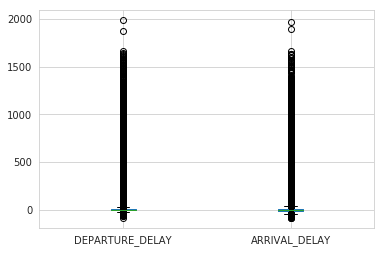

In [17]:
df_delayed_flights[["DEPARTURE_DELAY","ARRIVAL_DELAY"]].plot.box()
plt.show()

/home/tiffany/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tiffany/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


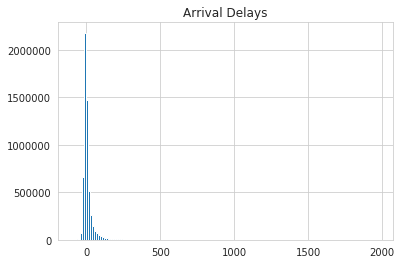

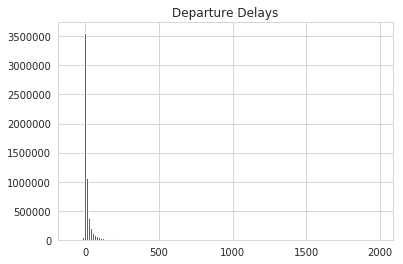

In [15]:
plt.hist(df_delayed_flights['ARRIVAL_DELAY'], bins=150)
plt.title("Arrival Delays")
plt.show()

plt.hist(df_delayed_flights['DEPARTURE_DELAY'], bins=150)
plt.title("Departure Delays")
plt.show()

In [18]:
#Determine Outliers

mean_arrival_delays = np.mean(df_delayed_flights['ARRIVAL_DELAY'] )
sd_arrival_delays = np.std(df_delayed_flights['ARRIVAL_DELAY'])

mean_departure_delays = np.mean(df_delayed_flights['DEPARTURE_DELAY'])
sd_departure_delays = np.std(df_delayed_flights['DEPARTURE_DELAY'])

print('Arrival Delays:\t \t Mean = {0} \t SD = {1}'.format(mean_arrival_delays, sd_arrival_delays))
print('Departure Delays:\t Mean = {0} \t SD = {1}'.format(mean_departure_delays, sd_departure_delays))


Arrival Delays:	 	 Mean = 4.407057357987598 	 SD = 39.27129365752419
Departure Delays:	 Mean = 9.370158275198389 	 SD = 37.080939262729146


In [19]:
#Arrrival_delay or Departure_delay <= 0 from calculations

#arrival_delays = df_delayed_flights[df_delayed_flights['ARRIVAL_DELAY'] > 0.00]['ARRIVAL_DELAY']
#departure_delays = df_delayed_flights[df_delayed_flights['DEPARTURE_DELAY'] > 0.00]['DEPARTURE_DELAY']


In [20]:
# Removing
flights_to_remove = []

# remove based on arrival and departure delays (normal distribution)
flights_to_remove = flights_to_remove + list(df_delayed_flights[df_delayed_flights['ARRIVAL_DELAY'] > mean_arrival_delays + 3.0* sd_arrival_delays].index)
flights_to_remove = flights_to_remove + list(df_delayed_flights[df_delayed_flights['ARRIVAL_DELAY'] < mean_arrival_delays - 3.0* sd_arrival_delays].index)

flights_to_remove = flights_to_remove + list(df_delayed_flights[df_delayed_flights['DEPARTURE_DELAY'] > mean_departure_delays + 3.0* sd_departure_delays].index)
flights_to_remove = flights_to_remove + list(df_delayed_flights[df_delayed_flights['DEPARTURE_DELAY'] < mean_departure_delays - 3.0* sd_departure_delays].index)

# remove based on arrival and departure delays ( <= 0 )
#flights_to_remove = flights_to_remove + list(df_delayed_flights[df_delayed_flights['ARRIVAL_DELAY'] <= 0].index)
#flights_to_remove = flights_to_remove + list(df_delayed_flights[df_delayed_flights['DEPARTURE_DELAY'] <= 0].index)

print('')
print('# Flights to remove', len(flights_to_remove))



# Flights to remove 226984


In [21]:

new_delayed_flights = df_delayed_flights[~df_delayed_flights.index.isin(flights_to_remove)]
print("Was: ", df_delayed_flights.shape, " Now: ", new_delayed_flights.shape)


Was:  (5819079, 24)  Now:  (5692011, 24)


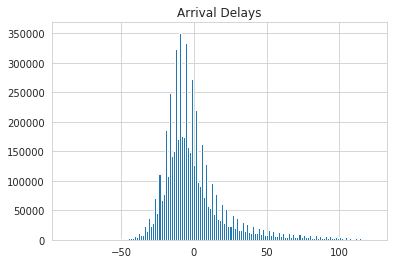

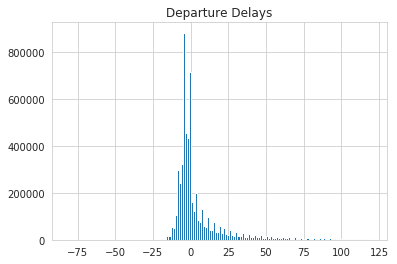

In [22]:

plt.hist(new_delayed_flights['ARRIVAL_DELAY'], bins=150)
plt.title("Arrival Delays")
plt.show()

plt.hist(new_delayed_flights['DEPARTURE_DELAY'], bins=150)
plt.title("Departure Delays")
plt.show()

## 5. Merging datasets

In [ ]:
df_merge_v1 = new_delayed_flights.copy()

#Merge Airlines and Flights dfs
df_merge_v1 = pd.merge(new_delayed_flights, df_airlines, left_on='AIRLINE', right_on='AIRLINE_CODE', how='left')

#Merge Airports and Flights dfs on Origin_Airport and Airport_Code
df_merge_v1 = pd.merge(df_merge_v1, df_airports, left_on='ORIGIN_AIRPORT', right_on='AIRPORT_CODE', how='left')
df_merge_v1.rename(columns={'ORIGIN_AIRPORT':'ORIGIN_AC', #Origin Airport Code
                            'AIRPORT_NAME':'ORIGIN_AIRPORT', #Origin Airport Name
                            'DESTINATION_AIRPORT': 'DESTINATION_AC'}, inplace=True) #Dest Airport Code
df_merge_v1.drop(['AIRLINE','AIRPORT_CODE'], axis=1, inplace=True)

#Merge Airports and Flights dfs on Destination_Airport and Airport_Code
df_merge_v1 = pd.merge(df_merge_v1, df_airports, left_on='DESTINATION_AC', right_on='AIRPORT_CODE', how='left')
df_merge_v1.rename(columns={'AIRPORT_NAME':'DESTINATION_AIRPORT'}, inplace=True) #Dest Airport Name

df_merge_v1.drop('AIRPORT_CODE', axis=1, inplace=True)

In [ ]:
print("Merged Dataframe Columns: \n", df_merge_v1.columns)

df_merge_v1[['ORIGIN_AIRPORT', 'ORIGIN_AC','DESTINATION_AIRPORT', 'DESTINATION_AC']]

## Save file

In [ ]:
df_merge_v1.to_csv('data/flightsmerged.csv', index=False)